# Exploration of performance data of AutoBooch kombucha brewing system 

In [2]:
import time                                                                                                                                                                             
import pandas as pd                                                                                                                                                                     
import matplotlib.pyplot as plt

Import data from the log file:

In [3]:
boochData = pd.read_csv("brew_log.txt", sep=" ", header=0)

Make sure it's OK (well, enough for jazz):

In [4]:
boochData.head()

,time,temp,state
0,1.521122e+09,24.312,OFF
1,1.521124e+09,24.250,OFF
2,1.521126e+09,24.437,OFF
3,1.521128e+09,24.562,OFF
4,1.521130e+09,24.500,OFF


Are there outliers? (of course there are)

In [5]:
boochData.max()

time     1.52301e+09
temp              85
state             ON
dtype: object

In [6]:
boochData.min()

time     1.52112e+09
temp          17.437
state            OFF
dtype: object

Let's have a quick look at the data (and set the axes and fonts):

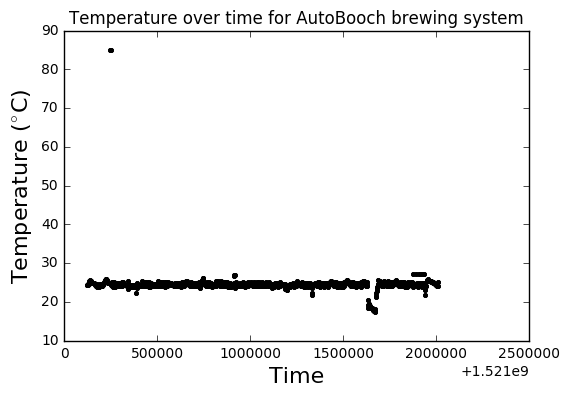

In [9]:
plt.rcParams["font.family"] = "serif"
plt.plot(boochData["time"], boochData["temp"],'.k')
plt.title(r'Temperature over time for AutoBooch brewing system')                                                                                                                        
plt.xlabel("Time", fontsize=16)                                                                                                                                                         
plt.ylabel(r'Temperature ($^{\circ}$C)', fontsize=16)
plt.show()

So we can see how far the outliers are out. 

The lonesome, very high, temperature (85°C) must have been from me leaving the sensor in the sun while changing a batch. Similarly, the low temperatures (down to 17°C) would have been from me leaving it exposed to the cool air. 

Also note the strange time axis—the default for the time modules is 'seconds since Unix epoch (January 1, 1970)'!

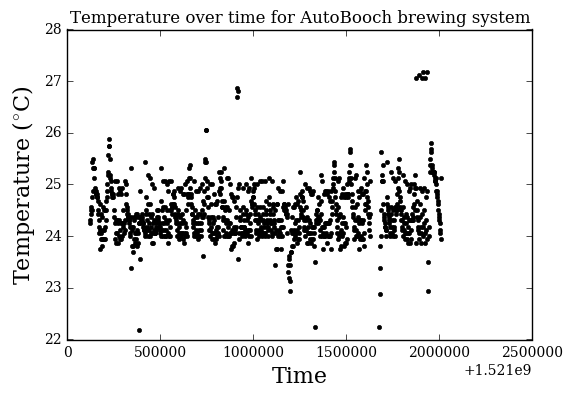

In [13]:
plt.plot(boochData["time"], boochData["temp"],'.k')
plt.title(r'Temperature over time for AutoBooch brewing system')                                                                                                                        
plt.xlabel("Time", fontsize=16)                                                                                                                                                         
plt.ylabel(r'Temperature ($^{\circ}$C)', fontsize=16)
plt.ylim( 22, 28 )
plt.show()

Define a function to get the hour of the day. This uses the funny syntax from the time module.

In [22]:
def t2hours(t):
    """Return the hour of the day from a time.time structure. Also convert from UTC to my time-zone (US Central, UTC-5)"""
    return (float(time.gmtime(t).tm_hour) + float(time.gmtime(t).tm_min)/60.0 - 5.0) % 24

In [23]:
boochData['hours'] = boochData.apply(lambda row: t2hours(row["time"]), axis=1)

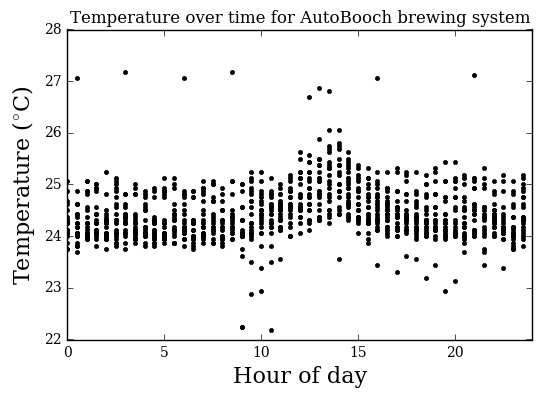

In [25]:
plt.plot(boochData["hours"], boochData["temp"],'.k')
plt.title(r'Temperature over time for AutoBooch brewing system')                                                                                                                        
plt.xlabel("Hour of day", fontsize=16)                                                                                                                                                         
plt.ylabel(r'Temperature ($^{\circ}$C)', fontsize=16)
plt.ylim( 22, 28 )
plt.xlim( 0, 24 )
plt.show()

In [41]:
import numpy as np
def rngAvg(x,y):
    return np.average(y[(y["hours"]==x)]["temp"])

In [68]:
y = []
t = np.arange(0,24,0.5,dtype="float")
y  = [rngAvg(x,boochData[(boochData["temp"]<30) & (boochData["temp"]>22)]) for x in t]

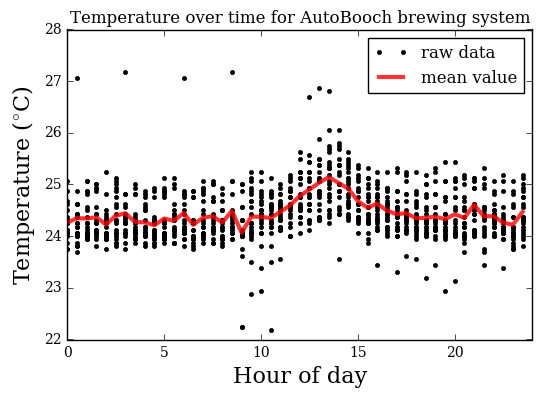

In [71]:
plt.plot(boochData["hours"], boochData["temp"],'.k',label="raw data")
plt.plot(t,y,'-r',linewidth=3,alpha=0.8,label="mean value")
plt.title(r'Temperature over time for AutoBooch brewing system')                                                                                                                        
plt.xlabel("Hour of day", fontsize=16)                                                                                                                                                         
plt.ylabel(r'Temperature ($^{\circ}$C)', fontsize=16)
plt.ylim( 22, 28 )
plt.xlim( 0, 24 )
plt.legend()
plt.show()